In [44]:
%pip install statsmodels



Note: you may need to restart the kernel to use updated packages.


Importing necessary libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()


ICE CREAM PRODUCTION DATA

In [46]:
data = pd.read_csv('Datasets/ice_cream.csv')
data.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [47]:
df=data
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [48]:
#Rename the column to make it understandable

In [49]:
df.rename(columns={'DATE':'date', 'IPN31152N':'production'},inplace=True)

In [50]:
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [51]:
#convert date column to datetime type from string
df['date'] = pd.to_datetime(df.date)
df['date'].dtype

dtype('<M8[ns]')

In [52]:
#set date as the index 
df.set_index('date', inplace=True)

In [53]:
# making the dataset smaller by using data from 2010 onwards for better understanding purpose

start_date = pd.to_datetime('2010-01-01')
df = df[start_date:]
df.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


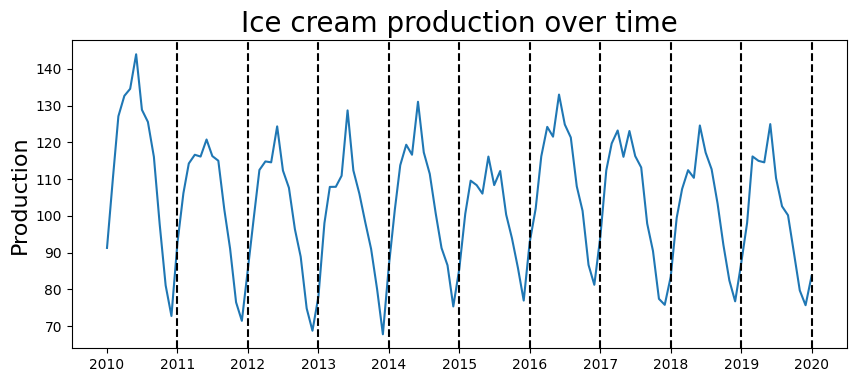

In [54]:
plt.figure(figsize=(10,4))
plt.plot(df.production)
plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle ='--')

In [55]:
#plotting acf plots

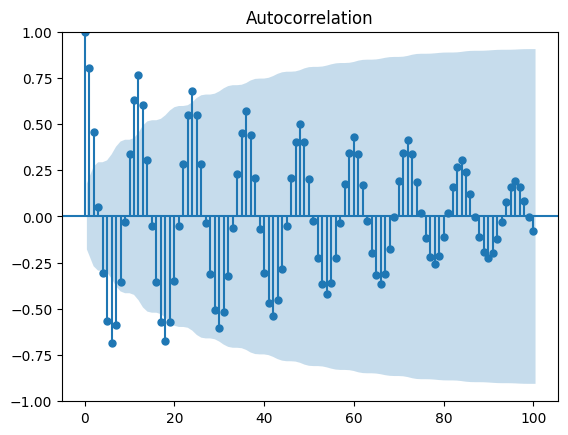

In [56]:
acf_plot = plot_acf(df.production,lags=100)

Based on the decaying ACF, we are likely dealing with an Auto Regressive process


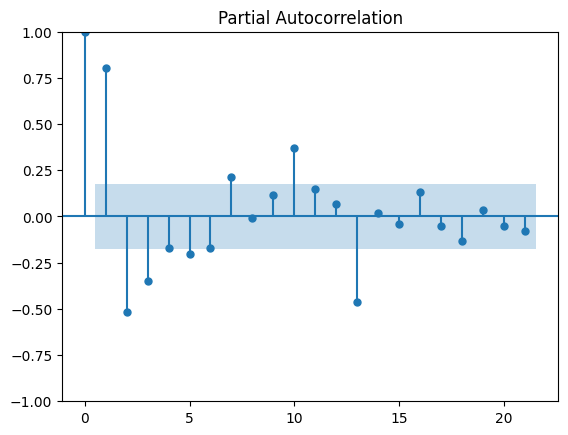

In [57]:
#Plotting PACF plots
pacf_plot = plot_pacf(df.production)

we ignore the autocoreelation at lag 0 because it is the autocorrelation of the model with itself so it is the highest i.e. 1,
Based on the PACF, we should start with an Auto Regressive model with lags 1,2,3,7,13

On Stock data

In [58]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [59]:
import yfinance as yf

In [60]:
#define the ticker symbol
tickerSymbol ='SPY'
#get data on this ticker
tickerdata = yf.Ticker(tickerSymbol)

In [61]:
#get the historical prices for this ticker
tickerDf = tickerdata.history(period ='1d', start='2015-1-1', end='2020-1-1')

Failed to get ticker 'SPY' reason: Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
$SPY: possibly delisted; no timezone found


In [62]:
%pip install --upgrade certifi


Note: you may need to restart the kernel to use updated packages.


Using Augmented Dickey-Fuller Test

In [63]:
from statsmodels.tsa.stattools import adfuller

In [64]:
def generate_ar_process(lags, coefs, length):
    #cast coefs to np array
    coefs = np.array(coefs)

    #initial values
    series = [np.random.normal() for _ in range(lags)]

    for _ in range(length):
        #get previous values of the series reversed
        prev_vals = series[-lags:][::-1]

        #get new value of the time series
        new_val = np.sum(np.array(prev_vals)*coefs) + np.random.normal()

        series.append(new_val)

    return np.array(series)

In [65]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF statistic: %f' % result[0])
    print('p-value: %f' % result[1])

AR(1) Process

Stationarity


Text(0.5, 1.0, 'Stationary AR(1) process')

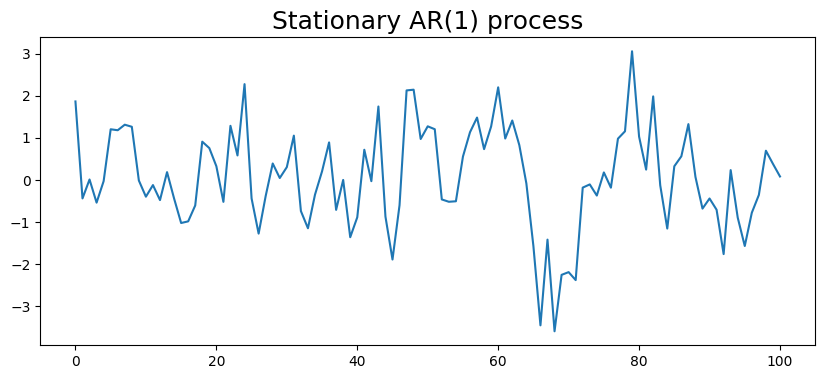

In [66]:
ar_1_process = generate_ar_process(1,[.5],100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process)
plt.title('Stationary AR(1) process', fontsize=18)


In [67]:
perform_adf_test(ar_1_process)

ADF statistic: -5.537169
p-value: 0.000002


Text(0.5, 1.0, 'Non-Stationary AR(1) process')

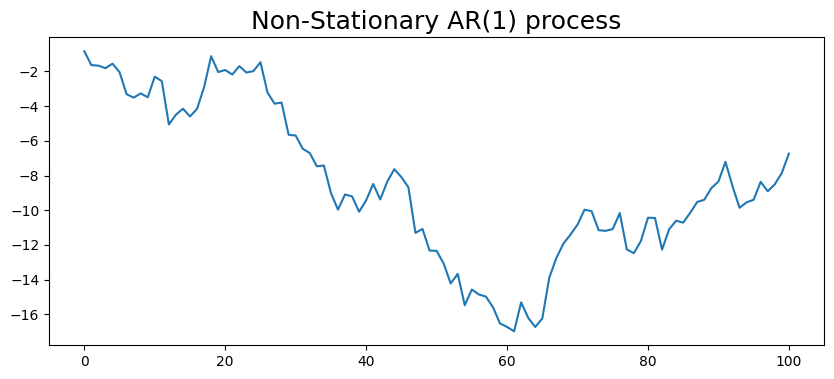

In [68]:
ar_1_process_unit_root = generate_ar_process(1,1,100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process_unit_root)
plt.title('Non-Stationary AR(1) process', fontsize=18)

In [69]:
perform_adf_test(ar_1_process_unit_root)

ADF statistic: -1.723000
p-value: 0.419303


From the ADF statistic and p-value we can conclude that this is not stationary.

Text(0.5, 1.0, 'Stationary AR(1) process')

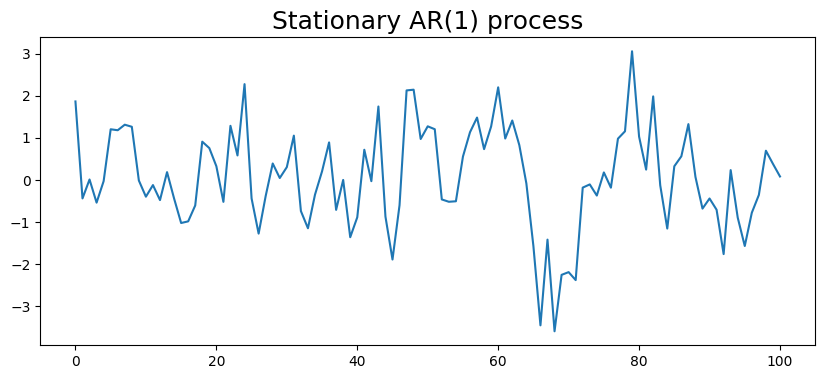

In [70]:
ar_1_process_neg_val = generate_ar_process(1,-1,100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process)
plt.title('Stationary AR(1) process', fontsize=18)

In [71]:
perform_adf_test(ar_1_process_neg_val)

ADF statistic: -6.897463
p-value: 0.000000


In [72]:
#yes it is indeed stationary!!

AR Model

In [73]:
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime,timedelta

In [74]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [75]:
d = pd.read_csv('Datasets/ice_cream.csv', parse_dates=[0], index_col=0, date_parser= parser)
d.head()

C:\Users\299957\AppData\Local\Temp\ipykernel_24384\1212314226.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  d = pd.read_csv('Datasets/ice_cream.csv', parse_dates=[0], index_col=0, date_parser= parser)


,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [76]:
d = pd.read_csv(
    'Datasets/ice_cream.csv',
    parse_dates=[0],
    index_col=0,
    date_parser=parser
)

# If your CSV has only one column besides the index:
d = d.iloc[:, 0]   # selects the first column as a Series

d = d.squeeze()  # after reading as DataFrame
d.head()


C:\Users\299957\AppData\Local\Temp\ipykernel_24384\1462445850.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  d = pd.read_csv(


DATE
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
Name: IPN31152N, dtype: float64

In [77]:
d.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [78]:
#infer the frequency of the data
d = d.asfreq(pd.infer_freq(d.index))

In [79]:
#just get data from 2010 onwards
d= d[start_date:]
d.head()

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
Freq: MS, Name: production, dtype: float64

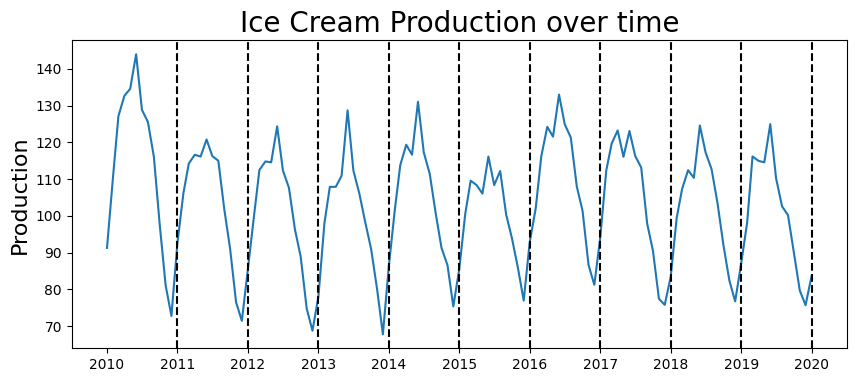

In [80]:
plt.figure(figsize=(10,4))
plt.plot(d)
plt.title('Ice Cream Production over time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')

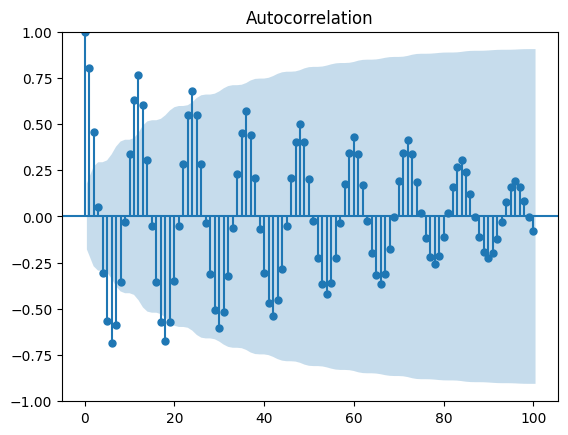

In [81]:
#plotting acf
acf_plot=plot_acf(d,lags=100)

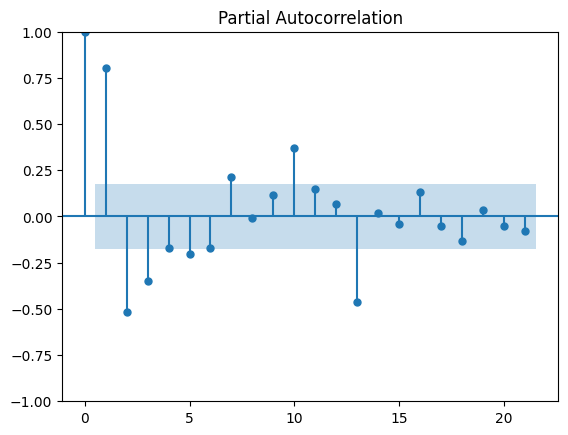

In [82]:
#plotting pacf
pacf_plot = plot_pacf(d)

Getting training and testing set

In [83]:
from time import time

In [84]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = d[:train_end]
test_data = d[train_end+ timedelta(days=1):test_end]

training the model with lag 3

In [85]:
#Fit the AR model

from statsmodels.tsa.arima.model import ARIMA

# ARMA(p,q) → ARIMA(p,d,q) with d=0
model = ARIMA(train_data, order=(3,0,0))
#fit the model
start = time()
model_fit = model.fit()
end=time()
print("Model fitting time is: ",end-start)

Model fitting time is:  0.14685869216918945


In [86]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Wed, 22 Oct 2025   AIC                            758.170
Time:                        10:23:42   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [87]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]



In [88]:
#get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data-predictions

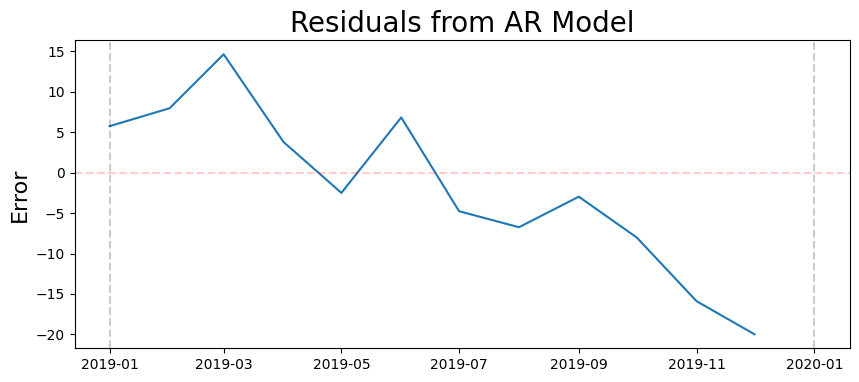

In [95]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--', alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--',alpha=0.2)

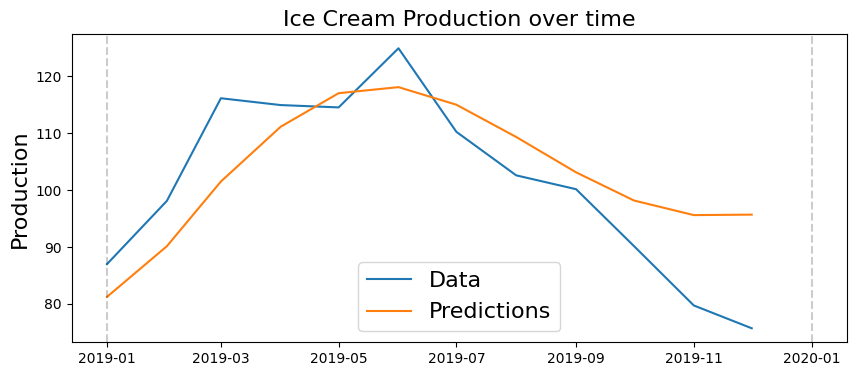

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'),fontsize=16)

plt.title('Ice Cream Production over time', fontsize=16)
plt.ylabel('Production', fontsize=16)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Mean Absolute Percent Error

In [ ]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error:  0.0895


In [ ]:
print('Root Mean Absolute Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Absolute Error:  9.884158748387852


In [90]:
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = d[:train_end]
test_data = d[train_end+ timedelta(days=1):test_end]

Now let's try to increase the complexity of the model by using AR7 model in place of AR3

In [92]:
from statsmodels.tsa.arima.model import ARIMA 
#creating the model

# ARMA(p,q) → ARIMA(p,d,q) with d=0
model = ARIMA(train_data, order=(7,0,0))
#fit the model
start = time()
model_fit = model.fit()
end=time()
print("Model fitting time is: ",end-start)

Model fitting time is:  0.3061237335205078


In [94]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -361.526
Date:                Wed, 22 Oct 2025   AIC                            741.051
Time:                        10:24:53   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6216      1.339     77.406      0.000     100.998     106.245
ar.L1          0.9497      0.097      9.837      0.000       0.760       1.139
ar.L2         -0.0964      0.131     -0.735      0.4

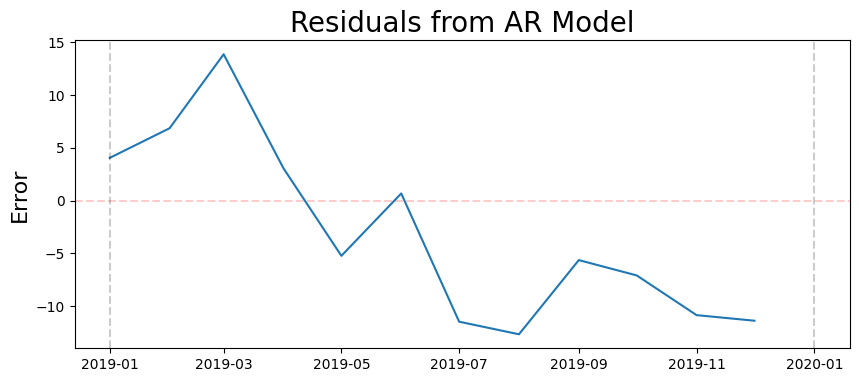

In [96]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
#get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data-predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--', alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--',alpha=0.2)

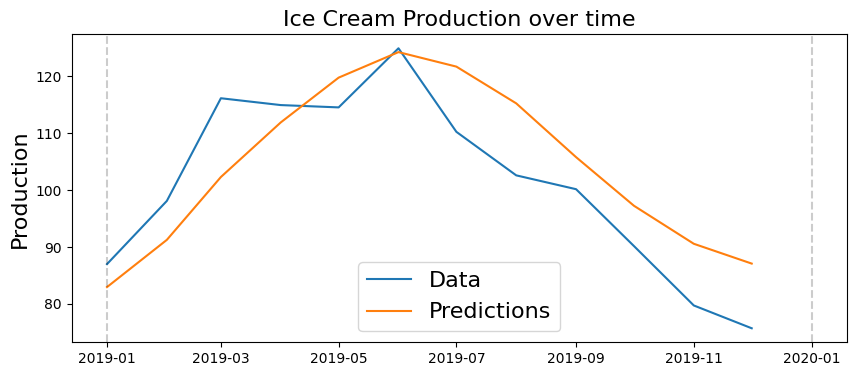

In [97]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'),fontsize=16)

plt.title('Ice Cream Production over time', fontsize=16)
plt.ylabel('Production', fontsize=16)

for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [98]:
#MAPE and RMSE
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Absolute Error: ', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error:  0.0802
Root Mean Absolute Error:  8.72544037303914


Model Evaluation using train-test split of the ratio 7:3

In [102]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = d[:train_end]
test_data = d[train_end + timedelta(days=1):test_end]

In [103]:
#creating the model
model = ARIMA(train_data,order=(3,0,0))
#fitting the model
start=time()
model_fit = model.fit()
end = time()
print("model fitting time is: ", end-start)
print(model_fit.summary())

model fitting time is:  0.10476255416870117
                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Wed, 22 Oct 2025   AIC                            598.015
Time:                        10:51:12   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2   

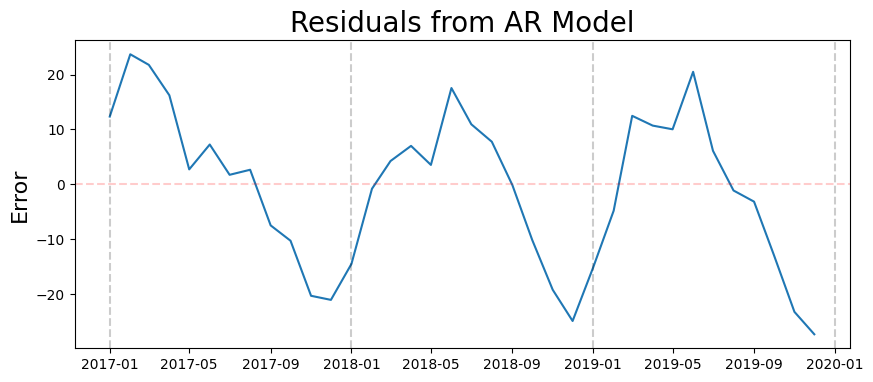

In [106]:
#get prediction start and end dates
pred_start_date =test_data.index[0]
pred_end_date = test_data.index[-1]
#get predictions and residuals
predictions = model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals = test_data - predictions

#plotting the residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r', linestyle='--', alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color ='k', linestyle='--', alpha=0.2)





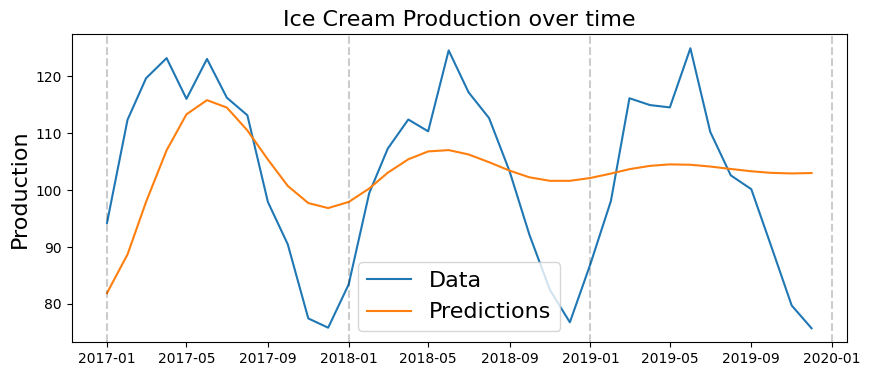

In [107]:
#plotting actual datapoints vs the predictions
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Ice Cream Production over time', fontsize=16)
plt.ylabel('Production', fontsize=16)

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+ '-01-01'), color='k', linestyle='--', alpha=0.2)


In [108]:
#MAPE and RMSE
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Absolute Error: ', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error:  0.1211
Root Mean Absolute Error:  13.890102335398788


MAPE and RMSE are not good

Rolling Forecast origin

In [111]:
#create the model
predictions_rolling = pd.Series()

for end_date in test_data.index:
    train_data = d[:end_date-timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit= model.fit()
    pred = model_fit.predict(start=end_date,end=end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

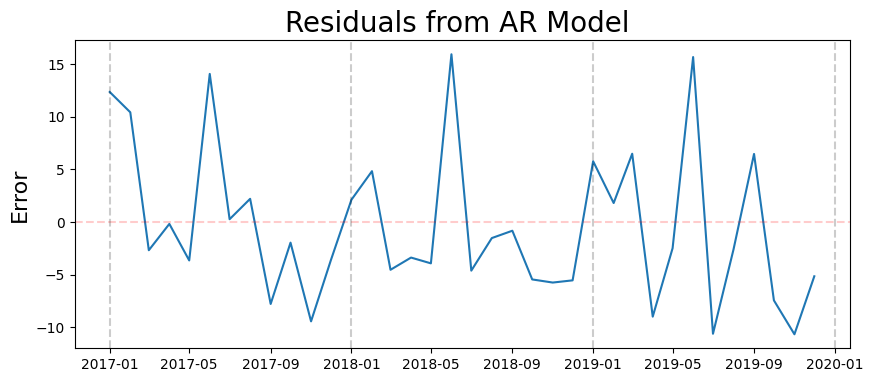

In [112]:
residuals_rolling = test_data - predictions_rolling
#now plotting the residuals_rolling
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model ',fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0,color='r',linestyle='--', alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

There is no such pattern as there was in the previous residuals plot when we were predicting using the 7:3 train_test split, so it is better than before.

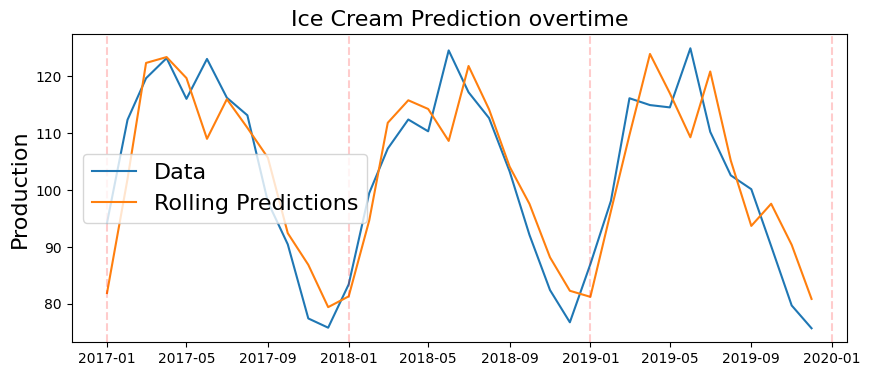

In [113]:
#Now lets plot the predictions vs actual data
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data','Rolling Predictions'),fontsize=16)
plt.ylabel('Production', fontsize=16)
plt.title('Ice Cream Prediction overtime', fontsize=16)

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='r', linestyle='--', alpha=0.2)

Here we can see that the forcasting is better as compared to the one we did using train_test split of the ratio 7:3, were we predicted the production all at once for the entire year, whereas in the second case we are using the rolling forecast where we forecast one month in advance and then include that in the training set for the prediction of next month.

In [116]:
#Now calculating the mean and rmse
print('Mean Absolute Prediction Error: ', round(np.mean(abs(residuals_rolling/test_data)),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))

Mean Absolute Prediction Error:  0.0582
Root Mean Squared Error:  13.890102335398788


MA Model Usage Example

In [ ]:
#Generating data

yt = 50 + 0.4(Et-1)+0.3(Et-2)+Et #Equation for MA model 50 is the mean value and 0.4 and 0.3 are respectively the coefficients for lag 1 and lag2.

Et ~ N(0,1) # it is assumed that the error is normallly distributed.

In [118]:
errors = np.random.normal(0,1,400)
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')
mu=50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu+ 0.4*errors[t-1]+0.3*errors[t-2]+errors[t])

In [121]:
series = pd.Series(series, date_index)
series= series.asfreq(pd.infer_freq(series.index))
series

2019-09-01    47.984875
2019-09-02    47.685692
2019-09-03    49.204433
2019-09-04    49.696011
2019-09-05    50.509596
                ...    
2019-12-28    49.441750
2019-12-29    48.568951
2019-12-30    50.136185
2019-12-31    50.676006
2020-01-01    50.430915
Freq: D, Length: 123, dtype: float64

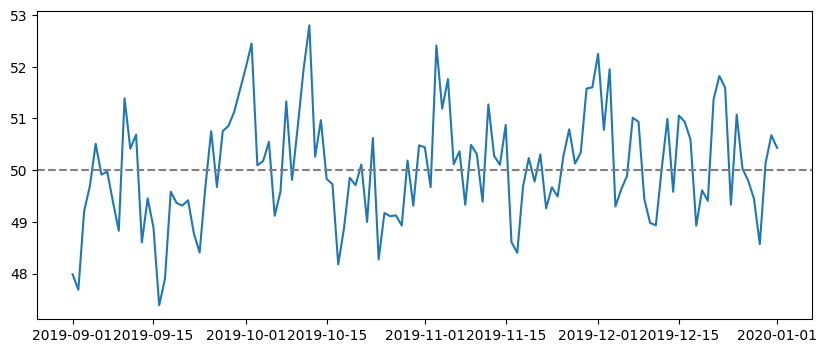

In [122]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

Generating the ACF and PACF plots


<BarContainer object of 10 artists>

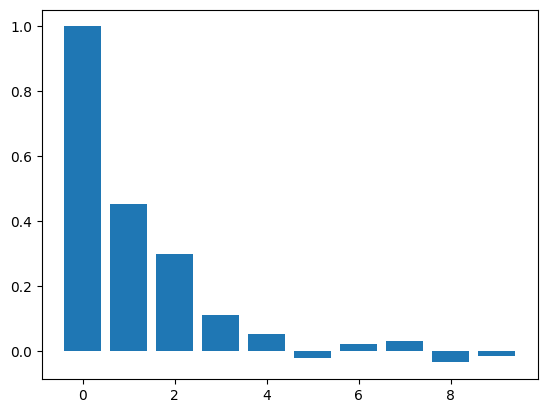

In [127]:
from statsmodels.tsa.stattools import acf, pacf
acf_vals = acf(series)
num_lags=10
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 21 artists>

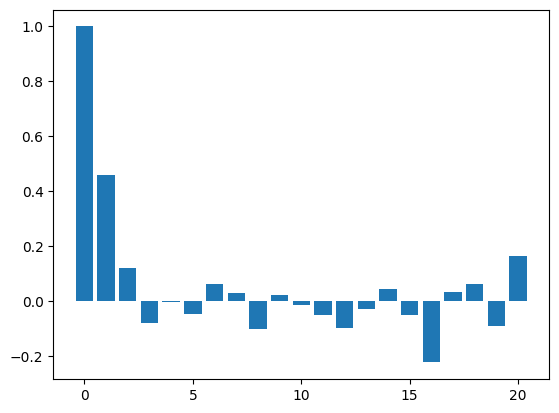

In [130]:
pacf_vals = pacf(series)
num_lags=len(pacf_vals)
plt.bar(range(num_lags),pacf_vals[:num_lags])

Get Training and Testing sets


In [142]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]


Fit ARIMA Model

In [143]:
#create the model
model = ARIMA(train_data, order=(0,0,2))
#here the order we are giving i.e 2 is also the only period to which we can forecast after that it will predict the constant mean of 50

#fit the model
model_fit= model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -164.781
Date:                Wed, 22 Oct 2025   AIC                            337.563
Time:                        14:36:57   BIC                            348.746
Sample:                    09-01-2019   HQIC                           342.105
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0335      0.140    358.509      0.000      49.760      50.307
ma.L1          0.3908      0.087      4.479      0.000       0.220       0.562
ma.L2          0.2617      0.100      2.628      0.0

Predicted Model
y't = 50 + 0.39(et-1)+ 0.26(et-2) + et

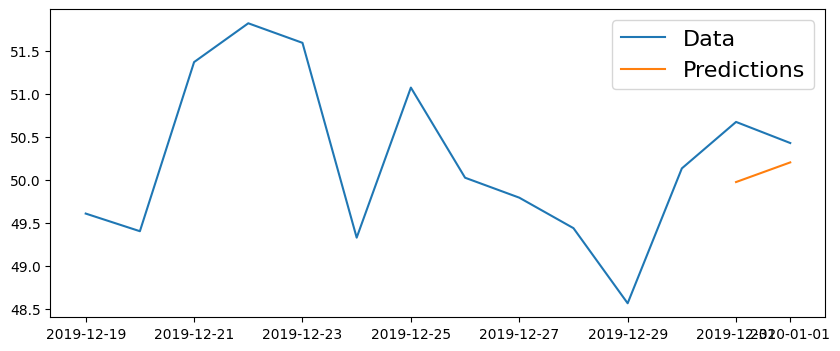

In [144]:
#get prediction start and end date
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

#plotting the residuals
plt.figure(figsize=(10,4))
plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

MAPE and RMSE

In [148]:
print('Mean Absolute Percent Error ', round(np.mean(abs(residuals/test_data)),4))
print('Roor mean Squared Error ',np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error  0.0091
Roor mean Squared Error  0.5189292230096919
